<a href="https://colab.research.google.com/github/turagsarkar/Machine-learning/blob/main/Image_Based_Plant_leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***`Using deep transfer learning approch for Image-Based Plant leaf Disease Detection model based on computer vision`***

***Dataset collection from***
https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/data


In [ ]:
#collcting data from google drive
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#libaray import
import keras
import numpy as np
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [ ]:
#Load data using a Keras utility
batch_size = 16
img_height = 256
img_width = 256
data_dir='/content/drive/MyDrive/leaf/Train/Train'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1322 files belonging to 3 classes.
Using 1058 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Powdery', 'Rust']


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1322 files belonging to 3 classes.
Using 264 files for validation.


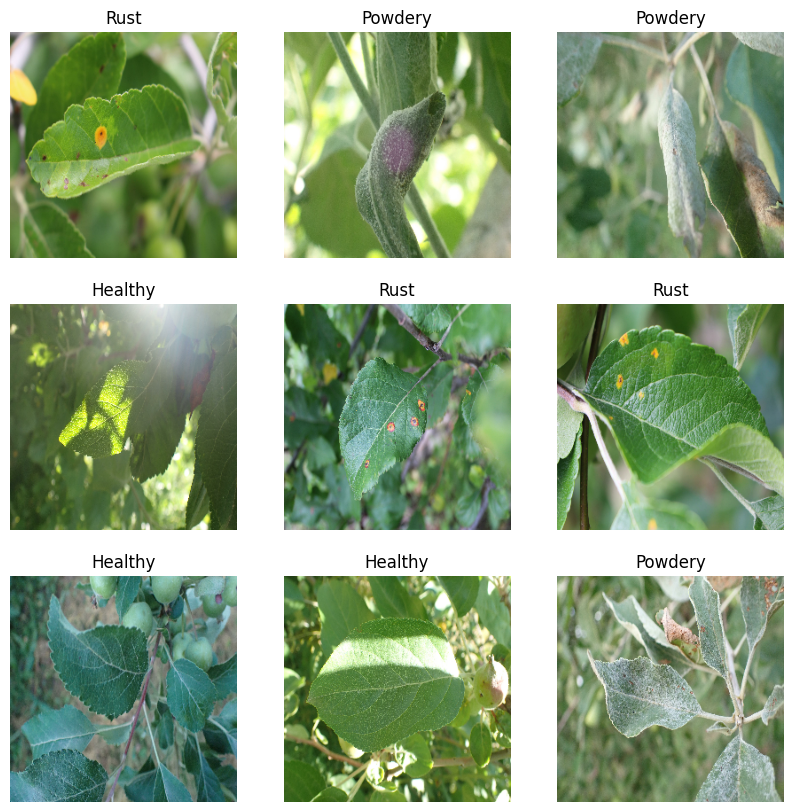

In [ ]:
#Data Exploration and Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [ ]:
data='/content/drive/MyDrive/leaf/Test/Test'

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  seed=123,
  image_size=(img_height, img_width),
  validation_split = 0,
  batch_size=batch_size)

Found 150 files belonging to 3 classes.


In [ ]:
print('\nTraining Dataset:', train_ds)
print('\nTesting Dataset:', test_ds)
print('\nValidation Dataset:', val_ds)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# Checking minimum and maximum pixel values in the train dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.03284314 1.0


In [ ]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in val_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


In [ ]:
#data augmentation
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = 123),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = 123),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = 123)
    ]
)

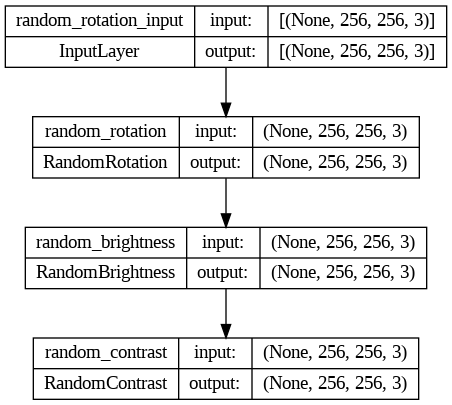

In [ ]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

In [ ]:
import keras
model = keras.Sequential()

model.add(augmentation)

# Feature Layers
model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (256,256,3) # Input image shape
                    ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

    # Flattening tensors
model.add(Flatten())

    # Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

    # Output Layer
model.add(Dense(3, activation = 'softmax')) # Classification layer

In [ ]:
model.compile(optimizer='sgd',
              loss=keras.losses.sparse_categorical_crossentropy, # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('model_new.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
try:
    history = model.fit(
        train_ds, epochs = 30,
        validation_data = test_ds,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 10.6950 - accuracy: 0.3374

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 101s 1s/step - loss: 10.6950 - accuracy: 0.3374 - val_loss: 53.0862 - val_accuracy: 0.3333
Epoch 2/30
67/67 [==============================] - 49s 645ms/step - loss: 1.1174 - accuracy: 0.3393 - val_loss: 151.7704 - val_accuracy: 0.3333
Epoch 3/30
67/67 [==============================] - 51s 684ms/step - loss: 1.1055 - accuracy: 0.3667 - val_loss: 151.0787 - val_accuracy: 0.3333
Epoch 4/30
67/67 [==============================] - 52s 709ms/step - loss: 1.1131 - accuracy: 0.3393 - val_loss: 80.9702 - val_accuracy: 0.3333
Epoch 5/30
67/67 [==============================] - 54s 712ms/step - loss: 1.1078 - accuracy: 0.3318 - val_loss: 25.2388 - val_accuracy: 0.3267
Epoch 6/30
67/67 [==============================] - 52s 720ms/step - loss: 1.1066 - accuracy: 0.3459 - val_loss: 8.8566 - val_accuracy: 0.3467
Epoch 7/30
67/67 [==============================] - 53s 739ms/step - loss: 1.1052 - accuracy: 0.3318 - val_loss: 12.1380 - val_accuracy: 0.3400
Epo

In [ ]:
!pip install gardio

ERROR: Could not find a version that satisfies the requirement gardio (from versions: none)
ERROR: No matching distribution found for gardio


In [ ]:

def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}


In [ ]:
#import gardio
#image = gardio.inputs.Image(shape=(256,256))
#label = gardio.outputs.Label(num_top_classes=5)

#gardio.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)
prediction = Dense(3, activation='softmax')(x)

# create a model object
conv_base = Model(inputs=inception.input, outputs=prediction)

In [ ]:
conv_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_102 (Conv2D)         (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_99 (Ba  (None, 111, 111, 32)         96        ['conv2d_102[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_100 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_99

In [ ]:
num_classes = 3
from tensorflow.keras.models import Sequential

model_new = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
img_height,img_width=224,224
batch_size=32
train_dsnew = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1322 files belonging to 3 classes.
Using 1058 files for training.


In [ ]:
val_dsnew = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1322 files belonging to 3 classes.
Using 264 files for validation.


In [ ]:
history = model.fit(train_dsnew,epochs=10,validation_data=val_dsnew)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 224, 224, 3)


In [ ]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import Sequential
model = Sequential()
model.add(augmentation)
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_4' (type Sequential).
    
    Input 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)
    
    Call arguments received by layer 'sequential_4' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
      • training=True
      • mask=None


In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 8, 8, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                           

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

17/17 [==============================] - 12s 265ms/step - loss: 0.2267 - accuracy: 0.3598


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.23
initial accuracy: 0.36


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
67/67 [==============================] - 68s 861ms/step - loss: 0.1482 - accuracy: 0.3166 - val_loss: 0.1362 - val_accuracy: 0.3598
Epoch 2/10
67/67 [==============================] - 61s 839ms/step - loss: 0.1395 - accuracy: 0.3166 - val_loss: 0.1235 - val_accuracy: 0.3598
Epoch 3/10
67/67 [==============================] - 53s 710ms/step - loss: 0.1086 - accuracy: 0.3166 - val_loss: 0.1212 - val_accuracy: 0.3598
Epoch 4/10
67/67 [==============================] - 51s 687ms/step - loss: 0.1031 - accuracy: 0.3166 - val_loss: 0.1205 - val_accuracy: 0.3598
Epoch 5/10
67/67 [==============================] - 52s 718ms/step - loss: 0.0909 - accuracy: 0.3166 - val_loss: 0.1204 - val_accuracy: 0.3598
Epoch 6/10
67/67 [==============================] - 61s 822ms/step - loss: 0.0777 - accuracy: 0.3166 - val_loss: 0.1209 - val_accuracy: 0.3598
Epoch 7/10
67/67 [==============================] - 58s 802ms/step - loss: 0.0784 - accuracy: 0.3166 - val_loss: 0.1208 - val_accuracy: 0.3598

In [ ]:
from keras.models import Sequential

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
IMAGE_SIZE = [256, 256]

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)

In [ ]:
folders=train_ds

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

In [ ]:
 model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)